In [2]:
from scripts.import_file import *

# 准备数据

In [3]:
df13 = pd.read_pickle('./data/grouped_13.df')
df14 = pd.read_pickle('./data/grouped_14.df')

In [ ]:
y13 = df13.pop('Yield')
y14 = df14.pop('Yield')

In [ ]:
X13 = df13.drop('Location', axis=1)
X14 = df14.drop('Location', axis=1)

In [ ]:
# reshape 901*186*16
def reshape_data(df):
    """
    reshape data to 901*16*186
    """
    res = []
    for row in df:
        new_row = []
        for col in row:
            new_row.append(col)
        res.append(new_row)
    return res

# 重绘地图

In [6]:
ct_data = pd.read_csv('./data/wheat-2013-supervised.csv')

In [22]:
ct_data.head()

,CountyName,State,Yield,fips
0,Adams,Washington,35.7,
1,Adams,Washington,35.7,
2,Adams,Washington,35.7,
3,Adams,Washington,35.7,
4,Adams,Washington,35.7,


In [19]:
ct_data = ct_data[['CountyName', 'State', 'Yield']]
ct_data['fips'] = ''

In [27]:
test_row = ct_data[:1]

In [39]:
test_row.State.values[0]

'Washington'

In [54]:
def find_fips(row):
#     print(row)
    state = row.State
    state_r = fips[fips.state_name == state]
    county = row.CountyName
    res = state_r[state_r['county_name'].str.contains(county)]
    return res.fips.values[0]

In [65]:
ct_data = ct_data.groupby(['CountyName', 'State']).mean().reset_index()

In [66]:
ct_data['fips'] = ct_data.apply(find_fips, axis=1)

In [69]:
plt_data = ct_data[['fips', 'Yield']]

In [42]:
tmp[tmp.county_name.apply(lambda x: 'Adams' in x)]

,fips,county_name,state_abbr,state_name
2957,53001,Adams County,WA,Washington


In [31]:
fips = pd.read_csv('./data/county_fips_master.csv')

In [13]:
county_data = f'{url}/us_county_data.csv'
df = pd.read_csv(county_data, na_values=[' '])
employed_series = df.set_index('FIPS_Code')['Employed_2011']

In [85]:
# bins = list(state_data['Unemployment'].quantile([0, 0.25, 0.5, 0.75, 1]))

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=county_geo,
    data=employed_series,
    columns=['fips', 'Yield'],
    key_on='feature.id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Unemployment Rate (%)',
#     bins=bins,
    reset=True
).add_to(m)

m

ValueError: key_on `'id'` not found in GeoJSON.

In [80]:
employed_series.max()

72.20000000000022

In [90]:
import branca
import json
import requests


url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'


# df = pd.read_csv(county_data, na_values=[' '])

colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 80)
employed_series = plt_data.set_index('fips')['Yield']

color_map = branca.colormap.linear.YlOrRd_09


def style_function(feature):
    employed = employed_series.get(int(feature['id'][-5:]), None)
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black' if employed is None else colorscale(employed)
    }


m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=3
)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function=style_function,
).add_to(m)

colormap = branca.colormap.linear.YlOrRd_09.scale(0, 80).to_step(10)
colormap.caption = 'Yield'
m.add_child(colormap)

m

In [91]:
m.save('map.html')

In [43]:
def make_heat_map(yd_loc):
    heat_map_data = []
    for row in yd_loc.values:
        row_data = []
        row_data.append(row[0][1])
        row_data.append(row[0][0])
        row_data.append(row[1])
        heat_map_data.append(row_data)
    return heat_map_data
hemap_data = make_heat_map(yd_loc)

In [44]:
hemap_data[0]

[45.8405591, -120.9140928, 43.699999999999875]

In [49]:
import folium
from folium.plugins import HeatMap

m = folium.Map(
    location=[39.9, -101],
    zoom_start=4,
    zoom_control=False,
    tiles='http://webrd02.is.autonavi.com/appmaptile?lang=en&size=1&scale=1&style=8&x={x}&y={y}&z={z}',
    attr="""&copy; <a href="http://ditu.amap.com/">高德地图</a>"""
    )
# m = folium.Map(location=[39.9, -101], zoom_start=4, zoom_control=False, width='70%',height='70%')

HeatMap(hemap_data).add_to(m)

# 模型

In [2]:
L2 = keras.regularizers.l2(1e-4)
model = keras.models.Sequential(name="yield_pre")
model.add(layers.Input(shape=(186, 16), name='input'))
model.add(
    layers.Bidirectional(
        layers.LSTM(32, 
                   kernel_regularizer=L2,
                   recurrent_regularizer=L2,
                   bias_regularizer=L2,
                   recurrent_initializer='glorot_uniform',
                   return_sequences=True,
                   name='LSTM-1'),
        merge_mode='concat',
        name='Bid-1'
    )
)
model.add(
    layers.Bidirectional(
        layers.LSTM(32, 
                   kernel_regularizer=L2,
                   recurrent_regularizer=L2,
                   bias_regularizer=L2,
                   recurrent_initializer='glorot_uniform',
                   return_sequences=True,
                   name='LSTM-2'),
        merge_mode='concat',
        name='Bid-2'
    )
)
model.add(
    layers.Bidirectional(
        layers.LSTM(32, 
                   kernel_regularizer=L2,
                   recurrent_regularizer=L2,
                   bias_regularizer=L2,
                   recurrent_initializer='glorot_uniform',
                   return_sequences=False,
                   name='LSTM-3'),
        merge_mode='concat',
        name='Bid-3'
    )
)
model.add(layers.Dense(1, name='output'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [ ]:
model.summary()

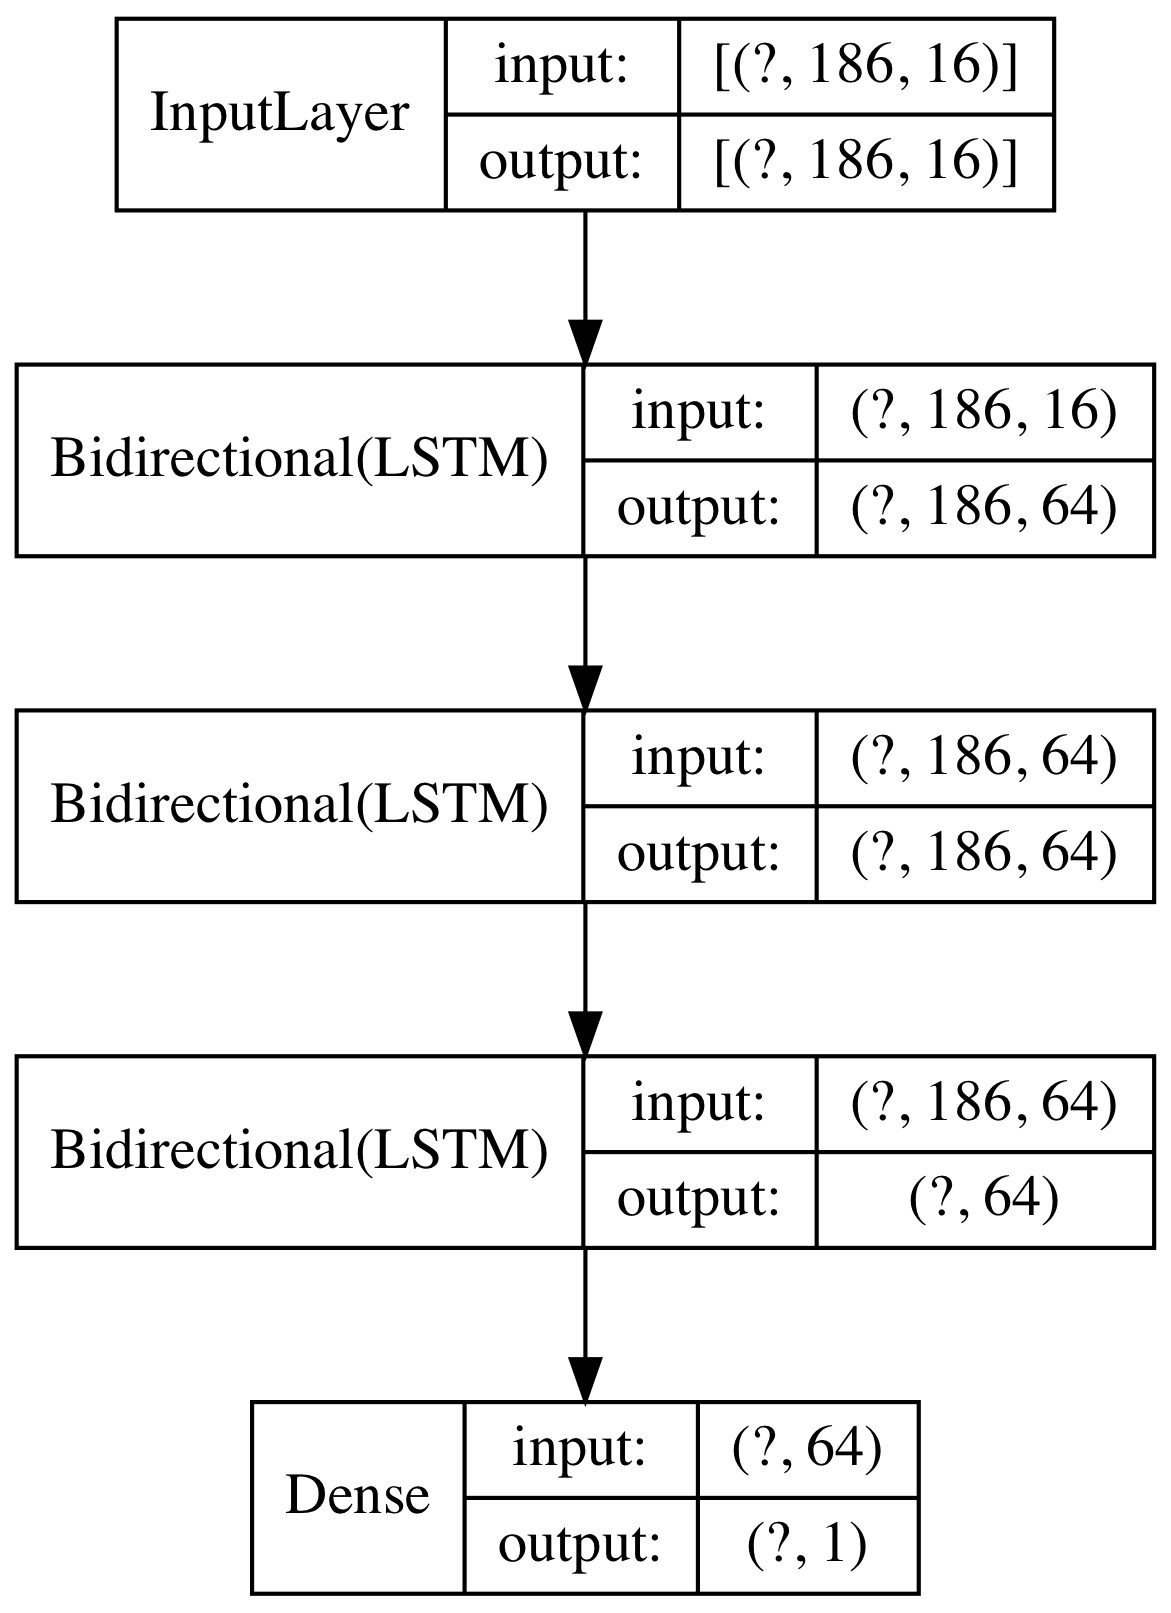

In [3]:
keras.utils.plot_model(model,show_shapes=True, show_layer_names=False, to_file='./Latex/figures/Model_figure.png', dpi=300)